**JADE CHANG**

Spring 2023

CS 251: Data Analysis and Visualization

Project 3: Linear regression

Polynomial regression

In [22]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import data
import linear_regression

plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=5)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Task 3: Polynomial Regression

We have been creating linear regression fits of form $y =c_0 + c_1x_1 + c_2x_2 + \ldots$, where $x_i$ are independent variables (columns of $A$) and $c_i$ are corresponding coefficients in $c$. However, this equation only allows us to fit data with a line/plane. This may not be the best choice for all datasets.

In this task, you will generalize the linear regression model form to include higher-degree (>1) polynomial terms and explore how this may improve fits to complex data. For example, assume we're doing a simple linear regression with independent variable $x_1$ and dependent variable $y$. A linear regression that fits data with a quadratic shape has the form$$y = c_0 + c_1x_1 + c_2x_1^2$$

Complete the following steps to add support for polynomial regression in your `LinearRegression` class.

### 3a) Build the polynomial matrix of the independent variable

The polynomial matrix contains the independent variable raised to a different power in each column. For example, if $A$ originally has a column vector for the independent variable $\vec{x_1}$ ($A = [\vec{x_1}]$) and we wanted to make the above quadratic model, we would append $x_1^2$ ($A = [\vec{x_1}, \vec{x_1^2}]$).

**TODO:**
Implement and test `LinearRegression::make_polynomial_matrix` (*helper method*) that takes care of raising the independent variable samples to different powers.

##### Test `make_polynomial_matrix`

In [23]:
test_A = np.r_[1:10].reshape((9, 1))
test_p = 3

# Test cubic
lin_reg = linear_regression.LinearRegression(data.Data())
print(f'Your polynomial matrix:\n{lin_reg.make_polynomial_matrix(test_A, 3)}')

true_mat = '''
[[  1.   1.   1.]
 [  2.   4.   8.]
 [  3.   9.  27.]
 [  4.  16.  64.]
 [  5.  25. 125.]
 [  6.  36. 216.]
 [  7.  49. 343.]
 [  8.  64. 512.]
 [  9.  81. 729.]]
'''
print('It should look like:\n', true_mat)

Your polynomial matrix:
[[  1   1   1]
 [  2   4   8]
 [  3   9  27]
 [  4  16  64]
 [  5  25 125]
 [  6  36 216]
 [  7  49 343]
 [  8  64 512]
 [  9  81 729]]
It should look like:
 
[[  1.   1.   1.]
 [  2.   4.   8.]
 [  3.   9.  27.]
 [  4.  16.  64.]
 [  5.  25. 125.]
 [  6.  36. 216.]
 [  7.  49. 343.]
 [  8.  64. 512.]
 [  9.  81. 729.]]



### 3b) Add support for polynomial regression

This can be performed in 3 steps:


1. Implement the `LinearRegression::polynomial_regression` method to perform the polynomial regression (*alternate option: you may instead update your `linear_regression` method. If you decide to go this route, add a keyword argument for the polynomial degree with a default value of 1 to preserve compatability with regular linear regression.*).
2. Update `LinearRegression::predict`: Run `make_polynomial_matrix` on the "A" matrix that enters into the computation $y = Ac$ if `self.p > 1`.
3. Add support for plotting polynomials in `LinearRegression::scatter` by generalizing the plotted regression line to a regression polynomial if `self.p > 1`:
    - Getting your polynomial "x" values: Run `make_polynomial_matrix` on your evenly-spaced line sample points. To get the shapes to work out, you may need to add a trailing singleton dimension to your "x" sample points. For example, if you have 1000 "x" sample points, make the shape `(1000, 1)` rather than `(1000,)`.
    - Getting your polynomial "y" values: Use matrix multiplication with your polynomial regression model slopes and/or intercepts.

*There is no explicit test code here — visualizing the fit in the next subtask will help you debug!*

### 3c) Run a polynomial regression

In this subtask, you will debug your polynomial regression implementation and experiment fitting some data with it.

#### Test: Polynomial regression with linear model ($p = 1$)

- In the cell below, fit the `poly_data.csv` dataset using polynomial regression where the polynomial degree $p = 1$.
- Use `scatter` to plot the results.
- Print out the mean squared error.

The plot created by running the below cell should "look right" to you.

71.81095284569933


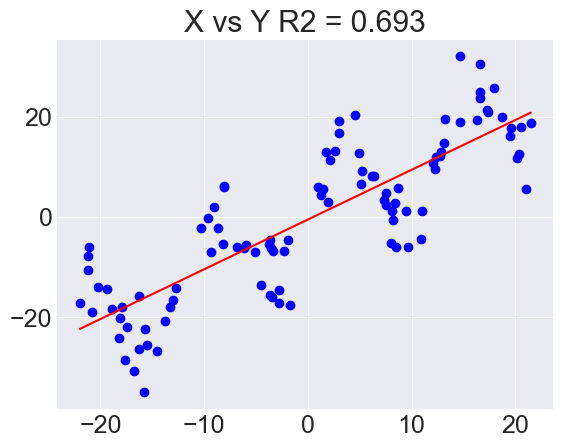

In [24]:
poly_data = data.Data("data/poly_data.csv")
A = linear_regression.LinearRegression(poly_data)

A.poly_regression("X","Y",1)
A.scatter("X","Y","X vs Y")
print(A.compute_mse())

#### Test: polynomial regression with high degree polynomials

Repeat the steps from the $p = 1$ test above in the cell below, but this time try $p = 7$. 

*Your regression fit should not be a line!*

55.03088073278098


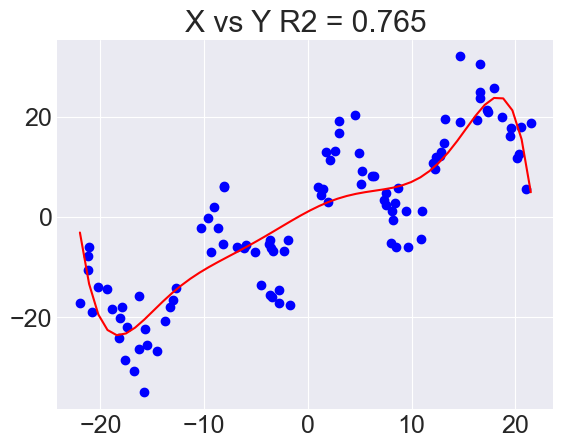

In [25]:
poly_regression = linear_regression.LinearRegression(poly_data)
poly_regression.poly_regression("X","Y",7)
poly_regression.scatter("X","Y","X vs Y")
print(poly_regression.mse)

**Question 4:** Describe the fit compared to `p=1` — is it better or worse? Why?

**Question 5:** Describe what happens visually and in terms of the $R^2$ and MSE values as you experiment with the polynomial degree between 1 and 7.

**Answer 4:** It is slightly better as its R2 is a bigger value. 

**Answer 5:** It increases slightly as we increase the degree.
The msse decreases as the degree increasees 

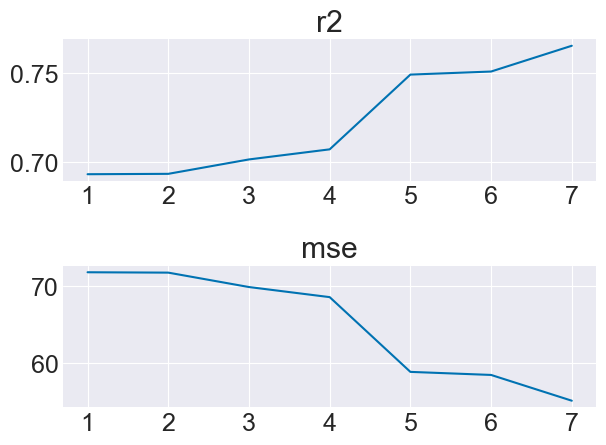

In [26]:
R2 = []
msse = []
p = list(range(1,8))
for i in range (1,8):
    poly_regression.poly_regression("X","Y",i)
    R2.append(poly_regression.R2)
    msse.append(poly_regression.mse)

fig,ax = plt.subplots(2)
ax[0].plot(p,R2)
ax[0].set_title("r2")
ax[1].plot(p,msse)
ax[1].set_title('mse')
plt.tight_layout()

## Task 4: Overfitting

In this subtask, you will experiment with how polynomial regression generalize to data not used to fit the regression model.

### 4a) Create fit and validation sets

The `poly_data.csv` dataset has 100 samples ($N=100$). In the cell below, split these samples into two separate "datasets" and create 2 `Data` objects representing:
- The first 50% of samples will be used to fit the regression model (i.e. run linear regression on these samples). We will call this the **fit set** (data used to fit the regression).
- The second 50% of samples will be set aside and only used to check how well the fitted regression generalizes to new data. We will call this the **validation set**.

The data samples are already shuffled.

*Hint: There is a helpful `Data` method for paring down a dataset into a certain range of samples.*

In [27]:
poly_data = data.Data("data/poly_data.csv")
poly_data.data.shape


fit = data.Data("data/poly_data.csv")
fit.limit_samples(0,50)
validation = data.Data("data/poly_data.csv")
validation.limit_samples(50,100)

print(fit)
print(validation)

--------------------------------
data/poly_data.csv (50x2)
Headers:
  X    Y    
-------------------------------
Showing first 5/50 rows.
2.147    11.382    
9.465    1.034    
4.52    20.251    
1.974    2.89    
-3.358    -6.809    

-------------------------------

--------------------------------
data/poly_data.csv (50x2)
Headers:
  X    Y    
-------------------------------
Showing first 5/50 rows.
-3.65    -4.658    
9.69    -6.107    
-21.986    -17.271    
-8.694    -2.22    
-15.536    -25.608    

-------------------------------



Printing the `Data` object storing the fit set should yield:

    -------------------------------
    data/polydata.csv (50x2)
    Headers:
    X	Y
    Types:
    numeric	numeric
    -------------------------------
    Showing first 5/50 rows.
    2.147	11.382
    9.465	1.034
    4.52	20.251
    1.974	2.89
    -3.358	-6.809

    -------------------------------

Printing the `Data` object storing the validation set should yield:

    -------------------------------
    data/polydata.csv (50x2)
    Headers:
    X	Y
    Types:
    numeric	numeric
    -------------------------------
    Showing first 5/50 rows.
    -3.65	-4.658
    9.69	-6.107
    -21.986	-17.271
    -8.694	-2.22
    -15.536	-25.608

    -------------------------------

### 4b) Check fit generalization on validation set

Here is the process for checking how well your fitted linear regression model generalizes to the validation data:
1. Create `Data` objects for both the fit and validation data sets (*as you have already done*).
2. Run linear regression on the fit set.
3. Create a new `LinearRegression` object associated with the validation data.
4. Copy over the fitted slope and intercept coefficients associated with the fit set to the validation set `LinearRegression` object.
5. Create a scatterplot by calling `scatter` to show the validation data and the regression curve that uses the coefficients fitted on the fit dataset (copied over in Step 4).
6. Calculate and report fit statistics (e.g. MSE, $R^2$).

Before doing this, implement the following methods to help you copy over the fitted slope, intercept and other data from your fit set `LinearRegression` object:

- `get_fitted_slope`: return the fitted regression slopes.
- `get_fitted_intercept`: return the fitted regression intercept.
- `initialize(ind_vars, dep_var, slope, intercept, p)`: set fields based on passed in parameter values.

#### Check overfitting with $p = 7$ polynomial regression model

In the cell below:

1. Fit a polynomial regression model with $p = 7$ on the fit set.
2. Create 2 scatter plots:
    - Showing the fit set and regression curve fitted to it.
    - Showing the validation set and regression curve that uses the fitted coefficients to the **fit set**.
3. Compute and print the MSE for both the fit and validation sets.

Use the 6 step process above to guide you through the setup.

Fit Dataset
MSSE:  38.30258184051851
Validation Dataset
MSSE:  96.45877543079379


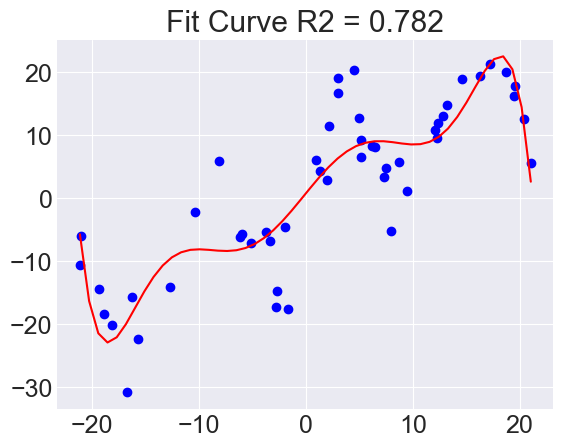

In [28]:
## Fit Curve
fit_regression = linear_regression.LinearRegression(fit)
fit_regression.poly_regression("X","Y",7)
fit_regression.scatter("X","Y","Fit Curve")

validation_regression = linear_regression.LinearRegression(validation)
validation_regression.initialize("X","Y",fit_regression.get_fitted_slope(),fit_regression.get_fitted_intercept(),7)
validation_regression.A = validation.select_data("X")
validation_regression.y = validation.select_data("Y")
validation_poly_matrix = validation_regression.make_polynomial_matrix(validation_regression.A,7)

y_pred = validation_regression.predict(validation_poly_matrix)
validation_regression.r_squared(y_pred)
validation_regression.R2 = validation_regression.r_squared(y_pred)
residuals = validation_regression.y - y_pred
#mean_sse = np.mean(residuals**2)
mean_sse = validation_regression.compute_mse()

print("Fit Dataset")
print("MSSE: ",fit_regression.compute_mse())
print("Validation Dataset")
print("MSSE: ",mean_sse)


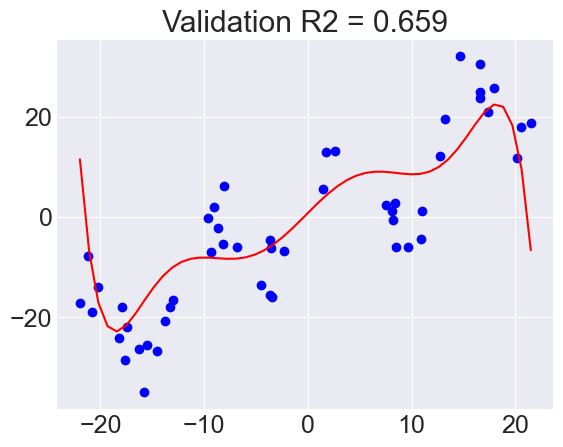

In [29]:
validation_regression.scatter("X","Y","Validation")

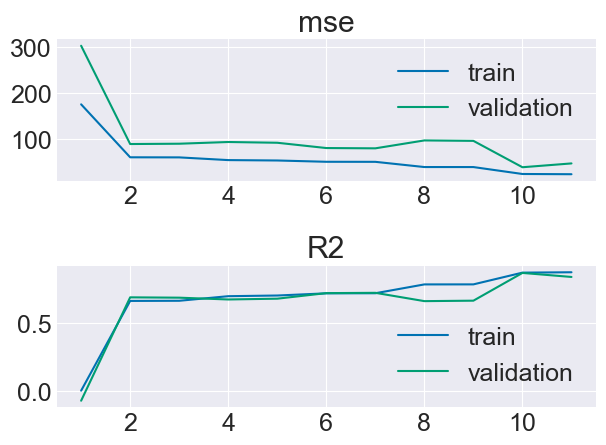

In [30]:
msse_fit = []
msse_validation = []
R2_fit = []
R2_validation = []
p = list(range(1,12))

for i in range (11):
    
    fit_regression = linear_regression.LinearRegression(fit)
    fit_regression.poly_regression("X","Y",i)
    msse_fit.append(fit_regression.compute_mse())
    R2_fit.append(fit_regression.R2)

    validation_regression = linear_regression.LinearRegression(validation)
    validation_regression.initialize("X","Y",fit_regression.get_fitted_slope(),fit_regression.get_fitted_intercept(),i)
    validation_regression.A = validation.select_data("X")
    validation_regression.y = validation.select_data("Y")
    validation_poly_matrix = validation_regression.make_polynomial_matrix(validation_regression.A,i)

    y_pred = validation_regression.predict(validation_poly_matrix)
    validation_regression.r_squared(y_pred)
    validation_regression.R2 = validation_regression.r_squared(y_pred)
    residuals = validation_regression.y - y_pred
    #mean_sse = np.mean(residuals**2)
    mean_sse = validation_regression.compute_mse()
    msse_validation.append(mean_sse)
    R2_validation.append(validation_regression.R2)

    


# print(msse_fit)
# print(msse_validation)
fig,ax = plt.subplots(2)
ax[0].plot(p,msse_fit,label = 'train')
ax[0].set_title("mse")
ax[0].plot(p,msse_validation, label = 'validation')
ax[0].legend()
#ax[1].set_title('mse_validation')

ax[1].plot(p,R2_fit,label = 'train')
ax[1].set_title("R2")
ax[1].plot(p,R2_validation, label = 'validation')
ax[1].legend()
#ax[3].set_title('mse_validation')
plt.tight_layout()


**Question 6:** Describe how the fitted coefficients obtained for the fit set generalize to the validation set. Do they do a good or bad job? Why?

**Question 7:** Does the generalization improve or worsen for polynomial degrees < 7? Are Back up your observations with numbers (e.g. MSE, $R^2$).

**Question 8:** Are there any values/ranges of polynomial degrees that generalize acceptably to the validation set? Why do you think so?

**Question 9:** What happens when you increase the polynomial degree above 7, in the range $7-13$? Why do you think this happens? Back up your observations with numbers (e.g. MSE, $R^2$).

**Answer 6:** The coefficients obtained suit the fit data set more, because R2 decreases in the validaiton dataset. It didn't do a good job, because R2 is higher in the fit data set, and lower in the validation set, suggesting that there is underfitting. 

**Answer 7:** The curve becomes less fit with a smaller polynomial degree. However, the generalization improves. The R2 are very similar for both fit (R2 = 0.716) and validation set (R2 = 0.717) at degree 5. 

**Answer 8:** 5-6 is the best. Because the R2 of both degree 5 and 6 are relatively high (around the 70s), and it can be generalised to both fit and validation, suggesting that the coefficients are good fits for both fit and validation set. 

**Answer 9:** The fit is the best at polynomial degree of 9, when both fit and validation dataset has R2 of 0.866. When we increase beyond degree 9, overfitting becomes more apparent. (Overfitting is when R2 is close to 1, but the MSSE is large)

In [31]:
poly_data = data.Data("data/poly_data.csv")
A = linear_regression.LinearRegression(poly_data)


## Extensions

To receive credit for any extension, you must:
- Not modify / prevent any code from the core project from working (e.g. make a copy before changing). In other words, **the notebook test code should still work!**
- **You must describe what you did and what you found in detail**. This includes a summary of parameter values used in your simulations.
- Include (*labeled!*) plots and/or numbers to present your results.
- Write up your extensions below or in a separate notebook.

**Rule of thumb: one deep, thorough extension is worth more than several quick, shallow extensions!**

**Reminder:** Give credit to all sources, including anyone that you consulted.

### 1. Your own data

- Run linear regression on datasets that interest you. Identify your hypotheses about the association between variables and test them out. Make plots and report all relevant metrics fit.

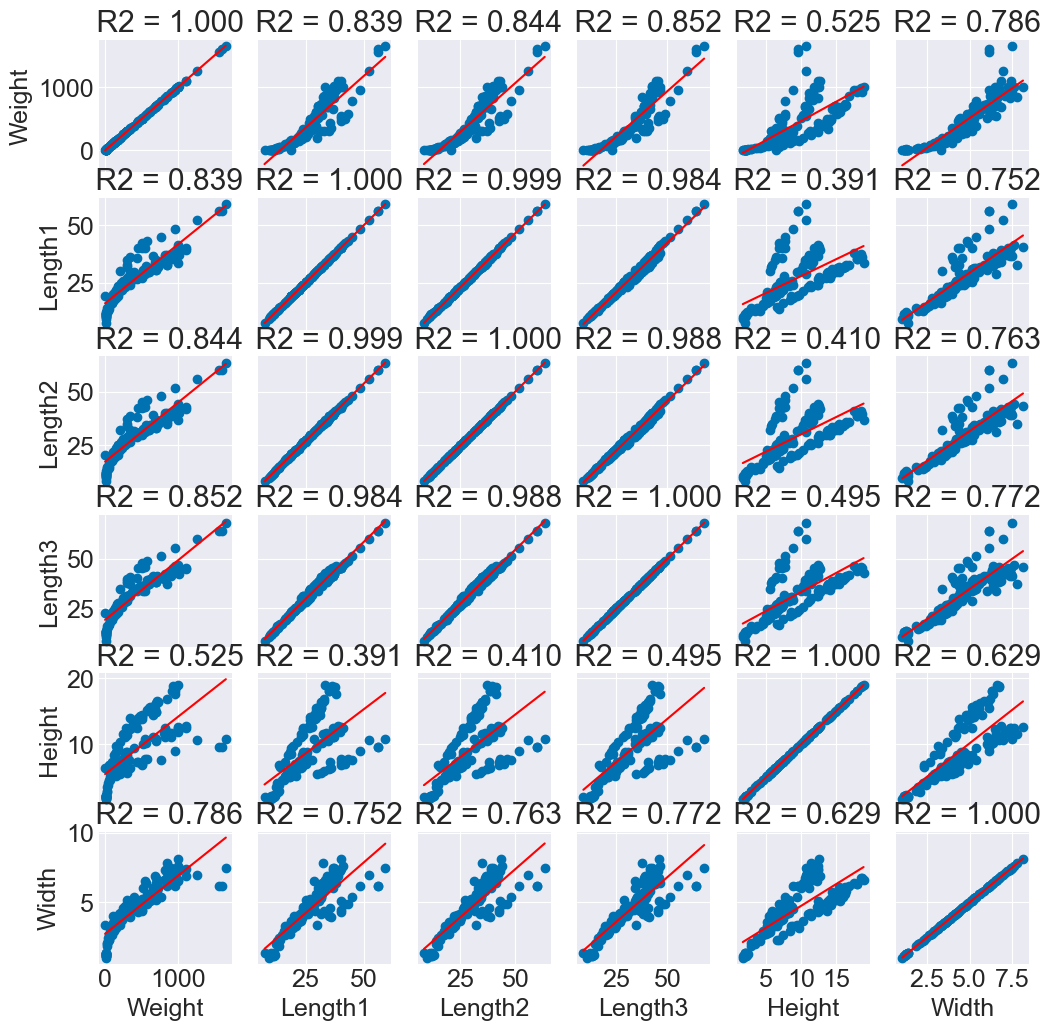

In [32]:
fish = data.Data("data/Fish.csv")
A = linear_regression.LinearRegression(fish)
A.pair_plot(fish.get_headers(), hists_on_diag=False)


According to the dataset description, length1 = vertical length in cm, length2 = diagonal length in cm, length3 = crosslength in cm
weight = weight of figh in g, width = diagonal width in cm.

Hypothesis: The different measurements of lengths are associated with each other. For example, the longer the vertical length, the longer its diagonal length as well as cross length. 

Looking at this graph, it looks like length 1 is strongly correlated with length 3. Length2 is also very strongly correlated with length 3.

Other observations: While we cannot fit a perfet linear line to Height and Weight, it is strongly correlated, and shows a similar trend depending on the species. It is a degree 2 regression, with different slopes (depending on the species).  

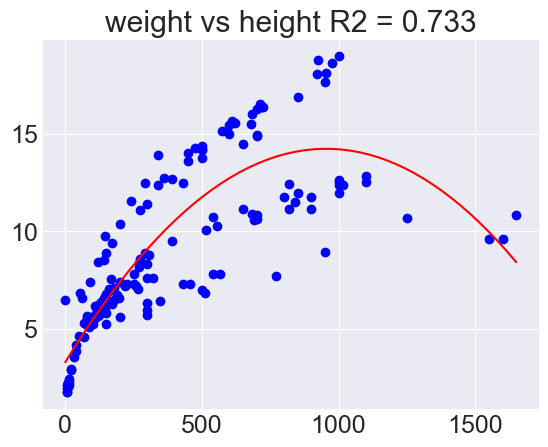

In [33]:
A.poly_regression("Weight","Height",2)
A.scatter("Weight","Height","weight vs height")

### 2. Linear regression algorithm comparison

- Research and implement other the linear regression solver methods (e.g. normal equations).
- Run and compare how well they do on a dataset of your choice.
- Research and implement matrix condition number. Find a dataset with a poor matrix condition number and then compare the regression methods. Which does best and why?

**Some of the most common linear regression methods are:**

Gradient Descent

Least Square Method / Normal Equation Method

Adams Method

Singular Value Decomposition (SVD)

and they each have their own strengths and weaknesses. 

Gradient Descent minimises error of prediction and data by applying gradient descent. The size of the step (alpha) decides the how fast the hypothesis converges to a global minimum. Its strenghs are that it is less computationally expensive than SVD and Adams. Its run time is O(kn^2). Weaknesses are that it might not find a global minimum or it might not converge and it needs a proper learning rate (alpha). 

Least Square Method uses linear algebra, and has benefits of having no learning rate and no iterations that work well when features are fewer. Its run time os O(n^3), and is computationally expensive, especially when there are more features or when the dataset is big. 

Admas Method is used in deep learning, and is a computationally efficient iteration program that works well with noisy data. Cons are that when the learning rate is unsuitable, it will fail to converge. 

Singular Value Decomposition (SVD) is a dimensionality reduction method used in linear regression. It is stable and reliable for small datasets, but inefficient for large datasets, as its runtime is O(n^3)

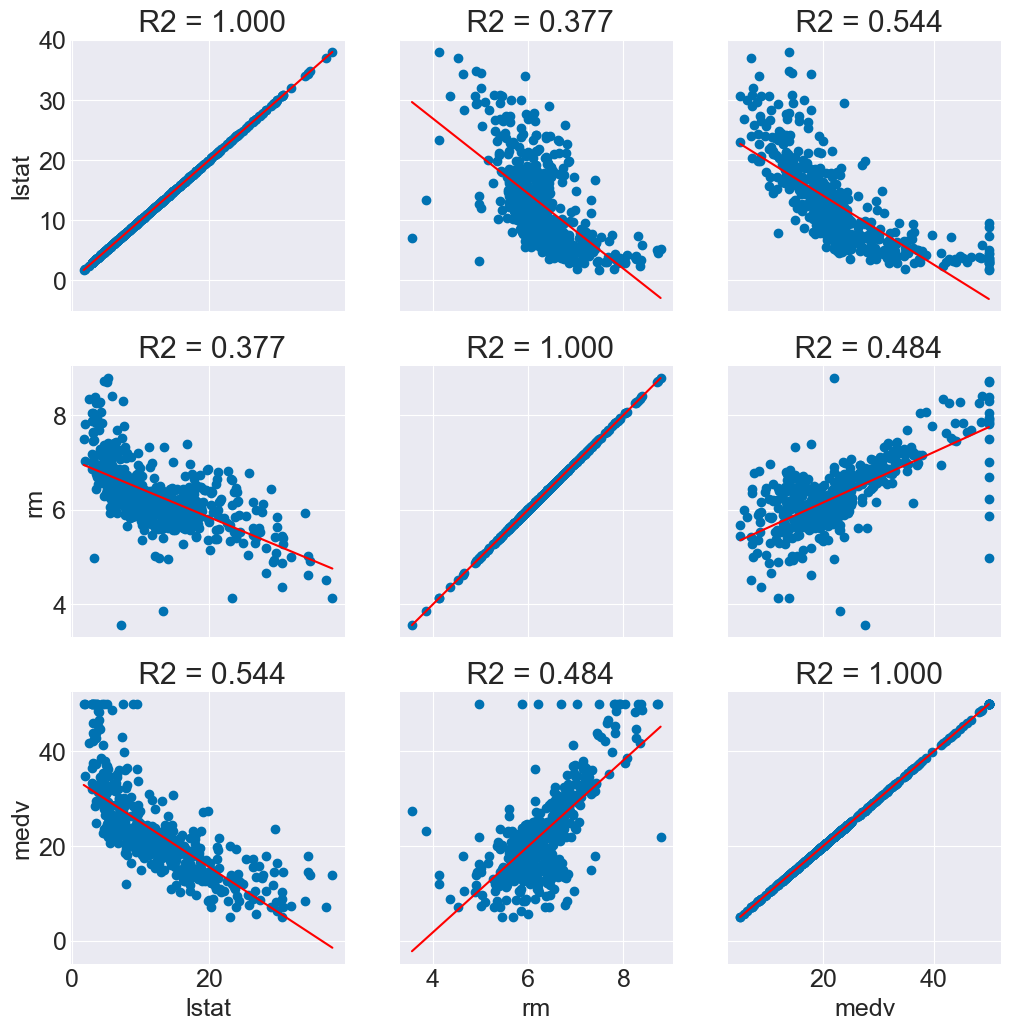

In [34]:
boston = data.Data("data/boston.csv")
reg = linear_regression.LinearRegression(boston)
reg.pair_plot(['lstat','rm','medv'], hists_on_diag=False)


In [99]:
import scipy.linalg as sp_la

X = boston.select_data("lstat")
y = boston.select_data("medv")
# Least Square/Normal Equation Method
def fitnorm(data, independent, dependent):
    # These are our independent variable(s)
    x = data[np.ix_(np.arange(data.shape[0]), independent)]
    # We add a column of 1s for the intercept
    A = np.hstack((np.array([np.ones(x.shape[0])]).T, x))
    # This is the dependent variable 
    y = data[:, dependent]
    # This is the regression coefficients that were fit, plus some other results
    c = sp_la.inv(A.T.dot(A)).dot(A.T).dot(y)
    return c

def predict(data, independent, c):
    # These are our independent variable(s)
    x = data[np.ix_(np.arange(data.shape[0]), independent)]
    # We add a column of 1s for the intercept
    A = np.hstack((np.array([np.ones(x.shape[0])]).T, x))
    return np.dot(A, c)

def plotxyyhat(x, y, c):
    plt.plot(x, y, 'o', label='data')
    xCurve = np.linspace(np.min(x), np.max(x))
    yCurve = c[0]
    for i in range(1, len(c)):
        yCurve += c[i]*(xCurve**i)
    plt.plot(xCurve, yCurve, label='least squares fit, linear')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(framealpha=1, shadow=True)
    plt.grid(alpha=0.25)
    plt.ylim(-1,60)
    plt.show()

c = fitnorm(boston.data, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 12)
yhat = predict(boston.data,[0,1,2,3,4,5,6,7,8,9,10,11],c)

plt.show()



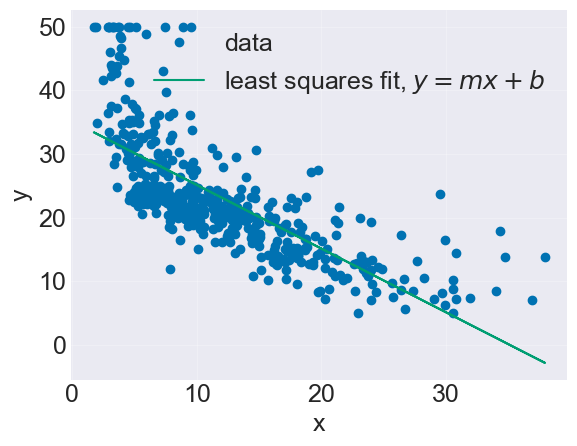

In [100]:
data = boston.data
split = np.array_split(data, 10)
train = np.vstack((split[0], split[1], split[7], split[3], split[4], split[5], split[6], split[8], split[9]))
test = split[2]


def getSummaryStatistics(data):
    return np.array([data.max(axis=0), data.min(axis=0), data.mean(axis=0, dtype=int)])

def getShapeType(data):
    return (data.shape, data.dtype)

def plotxyyhat(x, y, m, b):
    plt.plot(x, y, 'o', label='data')
    yhat = m*x + b
    plt.plot(x, yhat, label='least squares fit, $y = mx + b$')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(framealpha=1, shadow=True)
    plt.grid(alpha=0.25)
    plt.show()
    
def fit(data, independent, dependent):
    # These are our independent variable(s)
    x = data[np.ix_(np.arange(data.shape[0]), independent)]

    # We add a column of 1s for the intercept
    A = np.hstack((np.array([np.ones(x.shape[0])]).T, x))

    # This is the dependent variable 
    y = data[:, dependent]

    # This is the regression coefficients that were fit, plus some other results
    c, res, _, _ = sp_la.lstsq(A, y)
    return c

def predict(data, independent, c):
    # These are our independent variable(s)
    x = data[np.ix_(np.arange(data.shape[0]), independent)]

    # We add a column of 1s for the intercept
    A = np.hstack((np.array([np.ones(x.shape[0])]).T, x))

    return np.dot(A, c)

# assume these are numpy arrays
def rsquared(y, yhat):
    if len(y) != len(yhat):
        print("Need y and yhat to be the same length!")
        return 0
    return 1 - (((y - yhat)**2).sum() / ((y - y.mean())**2).sum())

c = fit(train, [11], 12)
yhat = predict(test, [11], c)
rsquared(test[:, 12], yhat)

plotxyyhat(train[:, 11], train[:, 12], c[1], c[0])

reference

the above cope is adaped from:
https://github.com/ajstent/CS252S22

https://www.kdnuggets.com/2020/09/solving-linear-regression.html


### 3. Confidence intervals or other kinds of error bars on linear regression plots

- Add the option to plot 95% confidence intervals on the linear regression predictions in your plot functions (e.g. `scatter`). [This website](https://real-statistics.com/regression/confidence-and-prediction-intervals/) should be a helpful reference.

### 4. Overfitting

- Run polynomial regression on other datasets. What degree polynomial works well? When do you overfit?

(413, 7)
Fit Dataset
MSSE:  130.69494186893945
Validation Dataset
MSSE:  134.1710018905381


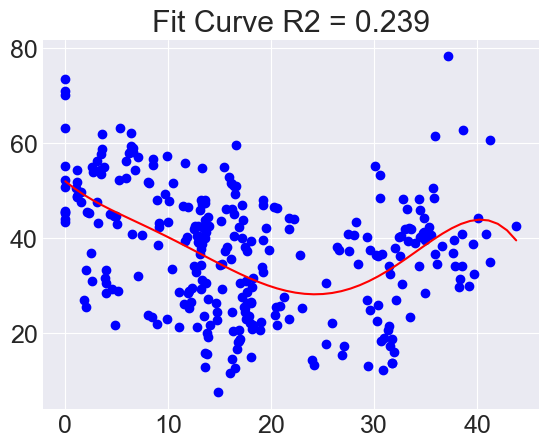

In [37]:
import data
real_estate = data.Data("data/Real estate valuation data set.csv")
print(real_estate.data.shape)

fit = data.Data("data/Real estate valuation data set.csv")
fit.limit_samples(0,300)
validation = data.Data("data/Real estate valuation data set.csv")
validation.limit_samples(301,413)

## Fit Curve
fit_regression = linear_regression.LinearRegression(fit)
fit_regression.poly_regression("X2 house age","Y house price of unit area",5)
fit_regression.scatter("X2 house age","Y house price of unit area","Fit Curve")

validation_regression = linear_regression.LinearRegression(validation)
validation_regression.initialize("X2 house age","Y house price of unit area",fit_regression.get_fitted_slope(),fit_regression.get_fitted_intercept(),5)
validation_regression.A = validation.select_data("X2 house age")
validation_regression.y = validation.select_data("Y house price of unit area")
validation_poly_matrix = validation_regression.make_polynomial_matrix(validation_regression.A,5)

y_pred = validation_regression.predict(validation_poly_matrix)
validation_regression.r_squared(y_pred)
validation_regression.R2 = validation_regression.r_squared(y_pred)
residuals = validation_regression.y - y_pred
#mean_sse = np.mean(residuals**2)
mean_sse = validation_regression.compute_mse()

print("Fit Dataset")
print("MSSE: ",fit_regression.compute_mse())
print("Validation Dataset")
print("MSSE: ",mean_sse)

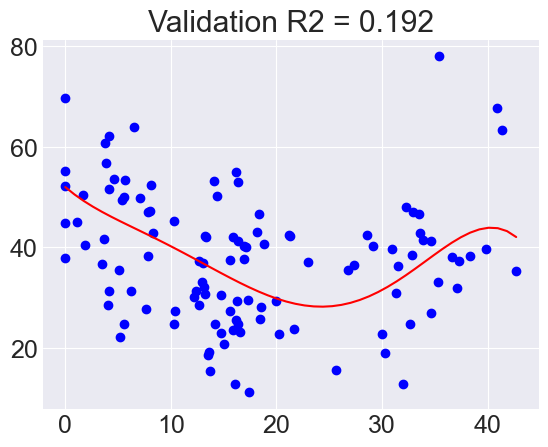

In [38]:
validation_regression.scatter("X2 house age","Y house price of unit area","Validation")

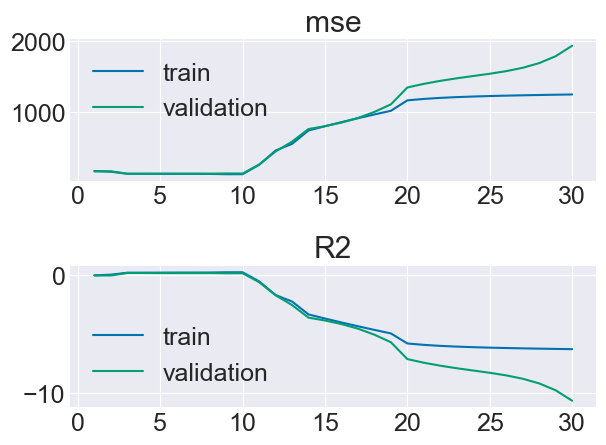

In [39]:
msse_fit = []
msse_validation = []
R2_fit = []
R2_validation = []
p = list(range(1,31))

for i in range (30):
    
    fit_regression = linear_regression.LinearRegression(fit)
    fit_regression.poly_regression("X2 house age","Y house price of unit area",i)
    msse_fit.append(fit_regression.compute_mse())
    R2_fit.append(fit_regression.R2)

    validation_regression = linear_regression.LinearRegression(validation)
    validation_regression.initialize("X2 house age","Y house price of unit area",fit_regression.get_fitted_slope(),fit_regression.get_fitted_intercept(),i)
    validation_regression.A = validation.select_data("X2 house age")
    validation_regression.y = validation.select_data("Y house price of unit area")
    validation_poly_matrix = validation_regression.make_polynomial_matrix(validation_regression.A,i)

    y_pred = validation_regression.predict(validation_poly_matrix)
    validation_regression.r_squared(y_pred)
    validation_regression.R2 = validation_regression.r_squared(y_pred)
    residuals = validation_regression.y - y_pred
    #mean_sse = np.mean(residuals**2)
    mean_sse = validation_regression.compute_mse()
    msse_validation.append(mean_sse)
    R2_validation.append(validation_regression.R2)

    


# print(msse_fit)
# print(msse_validation)
fig,ax = plt.subplots(2)
ax[0].plot(p,msse_fit,label = 'train')
ax[0].set_title("mse")
ax[0].plot(p,msse_validation, label = 'validation')
ax[0].legend()
#ax[1].set_title('mse_validation')

ax[1].plot(p,R2_fit,label = 'train')
ax[1].set_title("R2")
ax[1].plot(p,R2_validation, label = 'validation')
ax[1].legend()
#ax[3].set_title('mse_validation')
plt.tight_layout()

As we can see from the graph, there is an obvious overfitting when p > 20. R2 is higher (better fit) to the training dataset, but lower in the validation dataset. Furthermore, the mse is higher for validation. This shows that although the dataset fits the training dataset, it does not fit the validation data set as well. This is shows that there is overfitting.

### 5. Stepwise linear regression

- Implement the stepwise linear regression discussed in class where you add variables to the regression model one-by-one in a greedy fashion: each variable added out of the available ones not already entered in the regression should result in the largest increase in the adjusted $R^2$ value on the validation data.